# view 1t and 5 kt coeff

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tables
import h5py
import os, sys
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import curve_fit
from scipy.linalg import norm
from numpy.polynomial import legendre as LG

# 1t coeff
#### pe

In [2]:
def load_coeff(order):
    h = tables.open_file('../PE_coeff_1t' + order + '.h5','r')
    coeff_pe_in = h.root.poly_in[:]
    coeff_pe_out = h.root.poly_out[:]
    h.close()
    cut_pe, fitcut_pe = coeff_pe_in.shape

    h = tables.open_file('../Time_coeff_1t' + order + '.h5','r')
    coeff_time_in = h.root.poly_in[:]
    coeff_time_out = h.root.poly_out[:]
    h.close()
    cut_time, fitcut_time = coeff_time_in.shape
    return coeff_pe_in, coeff_pe_out, coeff_time_in, coeff_time_out, cut_pe, fitcut_pe, cut_time, fitcut_time

In [3]:
shell_in = 0.85 # Acrylic
shell_out = 0.8

def r2c(c):
    v = np.zeros(3)
    v[2] = c[0] * np.cos(c[1]) #z
    rho = c[0] * np.sin(c[1])
    v[0] = rho * np.cos(c[2]) #x
    v[1] = rho * np.sin(c[2]) #y
    return v

def c2r(c):
    v = np.zeros(3)
    v[0] = norm(c)
    v[1] = np.arccos(c[2]/(v[0]+1e-6))
    v[2] = np.arctan(c[1]/(c[0]+1e-6)) + (c[0]<0)*np.pi
    return v

def ReadPMT():
    f = open(r"../PMT_1t.txt")
    line = f.readline()
    data_list = [] 
    while line:
        num = list(map(float,line.split()))
        data_list.append(num)
        line = f.readline()
    f.close()
    PMT_pos = np.array(data_list)
    return PMT_pos

## Calculate the predict photon (by continous polynomial fit)

In [4]:
def CalcPredict(vertex):
    PMT_pos = ReadPMT()
    coeff_pe_in, coeff_pe_out, coeff_time_in, coeff_time_out, cut_pe, fitcut_pe, cut_time, fitcut_time = load_coeff('15')
    cut = 10
    radius = np.arange(0,0.65,0.01)/0.65
    expect = np.zeros((30,np.size(radius)))
    for z_index,z in enumerate(radius):
        if(z>shell_out):
            str_s = 'out'
            coeff = coeff_pe_out
        elif(z<shell_in):
            str_s = 'in'
            coeff = coeff_pe_in

        if z<1e-3:
            # assume (0,0,1)
            # cos_theta = PMT_pos[:,2] / norm(PMT_pos,axis=1)
            z = 1e-3
            v = vertex
            cos_theta = np.dot(v,PMT_pos.T) / (norm(v)*norm(PMT_pos,axis=1))
        else:
            v = vertex
            cos_theta = np.dot(v,PMT_pos.T) / (norm(v)*norm(PMT_pos,axis=1))
        # print(cos_theta)
        size = np.size(PMT_pos[:,0])
        x = np.zeros((size, cut))
        # legendre theta of PMTs
        for i in np.arange(0,cut):
            c = np.zeros(cut)
            c[i] = 1
            x[:,i] = LG.legval(cos_theta,c)
        # legendre coeff by polynomials
        k = np.zeros(cut)
        for i in np.arange(cut):
            # Legendre fit
            # k[i] = np.sum(np.polynomial.legendre.legval(z,coeff[i,:]))
            # polynomial fit

            if(i % 2 == 0):
                # k[i] = coeff[i,0] + coeff[i,1] * z ** 2 + coeff[i,2] * z ** 4 + coeff[i,3] * z ** 6 + coeff[i,4] * z ** 8 + \
                k[i] = np.sum(coeff[i,:] * z ** np.arange(0,2*np.size(coeff[i,:]),2))

            elif(i % 2 == 1):
                # k[i] = coeff[i,0] * z + coeff[i,1] * z ** 3 + coeff[i,2] * z ** 5 + coeff[i,3] * z ** 7 + coeff[i,4] * z ** 9
                k[i] = np.sum(coeff[i,:] * z ** np.arange(1,2*np.size(coeff[i,:])+1,2))
        expect[:,z_index] = np.exp(np.dot(x,k))
    return expect

In [5]:
expect_z = CalcPredict(np.array((0, 2, 10)))
expect_y = CalcPredict(np.array((0, 10, -2)))
expect_x = CalcPredict(np.array((10, 0, 0)))

## Calc prediction by discrete point

In [6]:
def CalcRawPre(vertex):
    PMT_pos = ReadPMT()
    radius = np.arange(0,0.66,0.01)
    predict = np.zeros((30,np.size(radius)))
    for z_index, z in enumerate(radius):
        if (z==0):
            z = 0.01 # file loss
        h = tables.open_file('../coeff_pe_1t_2.0MeV_dn/file_%.3f.h5' % z)
        k = h.root.coeff5[:]
        h.close()
        cut = np.size(k)
        if z<1e-3:
            # assume (0,0,1)
            # cos_theta = PMT_pos[:,2] / norm(PMT_pos,axis=1)

            v = vertex
            cos_theta = np.dot(v,PMT_pos.T) / (norm(v)*norm(PMT_pos,axis=1))
        else:
            v = vertex
            cos_theta = np.dot(v,PMT_pos.T) / (norm(v)*norm(PMT_pos,axis=1))
        # print(cos_theta)
        size = np.size(PMT_pos[:,0])
        x = np.zeros((size, cut))
        # legendre theta of PMTs
        for i in np.arange(0,cut):
            c = np.zeros(cut)
            c[i] = 1
            x[:,i] = LG.legval(cos_theta,c)
        # legendre coeff by polynomials
        predict[:,z_index] = np.exp(np.dot(x,k))
    return predict

In [7]:
bx = CalcRawPre(np.array((10,0,0)))
by = CalcRawPre(np.array((0,10,-2)))
bz = CalcRawPre(np.array((0,2,10)))

In [8]:
def readfile(filename):
    h1 = tables.open_file(filename,'r')
    print(filename)
    truthtable = h1.root.GroundTruth
    EventID = truthtable[:]['EventID']
    ChannelID = truthtable[:]['ChannelID']
    
    x = h1.root.TruthData[:]['x']
    y = h1.root.TruthData[:]['y']
    z = h1.root.TruthData[:]['z']
    #print(x.shape)
    #print(np.sum(x**2+y**2+z**2<0.1))
    #exit()
    h1.close()
    #print(x.shape, EventID.shape, np.unique(EventID).shape, np.std(y),np.sum(x**2+y**2+z**2>0.1))
    dn = np.where((x==0) & (y==0) & (z==0))
    dn_index = (x==0) & (y==0) & (z==0)
    #print(np.sum(dn_index))
    pin = dn[0] + np.min(EventID)
    if(np.sum(x**2+y**2+z**2>0.1)>0):
        cnt = 0        
        for ID in np.arange(np.min(EventID), np.max(EventID)+1):
            if ID in pin:
                cnt = cnt+1
                #print('Trigger No:', EventID[EventID==ID])
                #print('Fired PMT', ChannelID[EventID==ID])
                
                ChannelID = ChannelID[~(EventID == ID)]
                EventID = EventID[~(EventID == ID)]
                
                #print(cnt, ID, EventID.shape,(np.unique(EventID)).shape)
        x = x[~dn_index]
        y = y[~dn_index]
        z = z[~dn_index]
    #print(x.shape, EventID.shape, np.unique(EventID).shape,np.std(y),np.sum(x**2+y**2+z**2>0.1))
    return (EventID, ChannelID, x, y, z)

def readchain(radius, path, axis):
    for i in np.arange(0, 3):
        if(i == 0):
            #filename = path + '1t_' + radius + '.h5'
            filename = '%s1t_%s_%s.h5' % (path, radius, axis)
            EventID, ChannelID, x, y, z = readfile(filename)
        else:
            try:
                filename = '%s1t_%s_%s_%d.h5' % (path, radius, axis, i)
                EventID1, ChannelID1, x1, y1, z1 = readfile(filename)
                EventID = np.hstack((EventID, EventID1))
                ChannelID = np.hstack((ChannelID, ChannelID1))
                x = np.hstack((x, x1))
                y = np.hstack((y, y1))
                z = np.hstack((z, z1))
            except:
                pass

    return EventID, ChannelID, x, y, z

## Calculate the Mean Photon (by take mean of raw data)

In [9]:
def CalMean(axis):
    data = []
    PMT_pos = ReadPMT()
    for ra_index, ra in enumerate(np.arange(0.0001,0.70,0.05)):
        EventID, ChannelID, x, y, z = readchain('%+.2f' % ra, '/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/', axis)

        size = np.size(np.unique(EventID))
        total_pe = np.zeros(np.size(PMT_pos[:,0])*size)

        for k_index, k in enumerate(np.unique(EventID)):
                if not k_index % 1e4:
                    print('preprocessing %d-th event' % k_index)
                hit = ChannelID[EventID == k]
                tabulate = np.bincount(hit)
                event_pe = np.zeros(np.size(PMT_pos[:,0]))
                # tabulate begin with 0
                event_pe[0:np.size(tabulate)] = tabulate
                total_pe[(k_index) * np.size(PMT_pos[:,0]) : (k_index + 1) * np.size(PMT_pos[:,0])] = event_pe
                # although it will be repeated, mainly for later EM:
                # vertex[0,(k_index) * np.size(PMT_pos[:,0]) : (k_index + 1) * np.size(PMT_pos[:,0])] = x[k_index]
                # vertex[1,(k_index) * np.size(PMT_pos[:,0]) : (k_index + 1) * np.size(PMT_pos[:,0])] = y[k_index]
                # vertex[2,(k_index) * np.size(PMT_pos[:,0]) : (k_index + 1) * np.size(PMT_pos[:,0])] = z[k_index]
                # total_pe[(k_index) * np.size(PMT_pos[:,0]) : (k_index + 1) * np.size(PMT_pos[:,0])] = event_pe
        data.append(np.mean((np.reshape(total_pe, (30,-1), order='F')), axis=1))
    return data
    
    '''
    plt.figure(num = ra_index + 1,figsize=(20,10))
    plt.subplot(1,2,1)
    plt.plot(a)
    plt.plot(expect_z[:,ra_index*5])
    plt.xlabel('PMT No')
    plt.ylabel('Receive photons')
    plt.legend(['Mean','predict'])
    plt.title('radius = %.2f m' % ra)
    plt.subplot(1,2,2)
    plt.plot(a)
    plt.plot(expect_z[:,ra_index*5])
    plt.semilogy()
    plt.xlabel('PMT No')
    plt.ylabel('Receive photons')
    plt.legend(['Mean','predict'])
    plt.title('radius = %.2f m' % ra)
    plt.show()
    '''

In [10]:
ax = CalMean('x')
ay = CalMean('y')
az = CalMean('z')

/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.00_x.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.00_x_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.00_x_2.h5
preprocessing 0-th event
preprocessing 10000-th event
preprocessing 20000-th event
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.05_x.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.05_x_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.05_x_2.h5
preprocessing 0-th event
preprocessing 10000-th event
preprocessing 20000-th event
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.10_x.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.10_x_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.10_x_2.h5
preprocessing 0-th event
preprocessing 10000-th event
preprocessing 20000-th event
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.15_x.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.15_x_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.1

/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.15_z_2.h5
preprocessing 0-th event
preprocessing 10000-th event
preprocessing 20000-th event
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.20_z.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.20_z_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.20_z_2.h5
preprocessing 0-th event
preprocessing 10000-th event
preprocessing 20000-th event
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.25_z.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.25_z_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.25_z_2.h5
preprocessing 0-th event
preprocessing 10000-th event
preprocessing 20000-th event
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.30_z.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.30_z_1.h5
/mnt/stage/douwei/Simulation/1t_root/2.0MeV_xyz/1t_+0.30_z_2.h5
preprocessing 0-th event
preprocessing 10000-th event
preprocessing 20000-th event
/mnt/stage/douwei/Simulation/1t_ro

## Calculate the mean photon (discrete without polynomial fit)

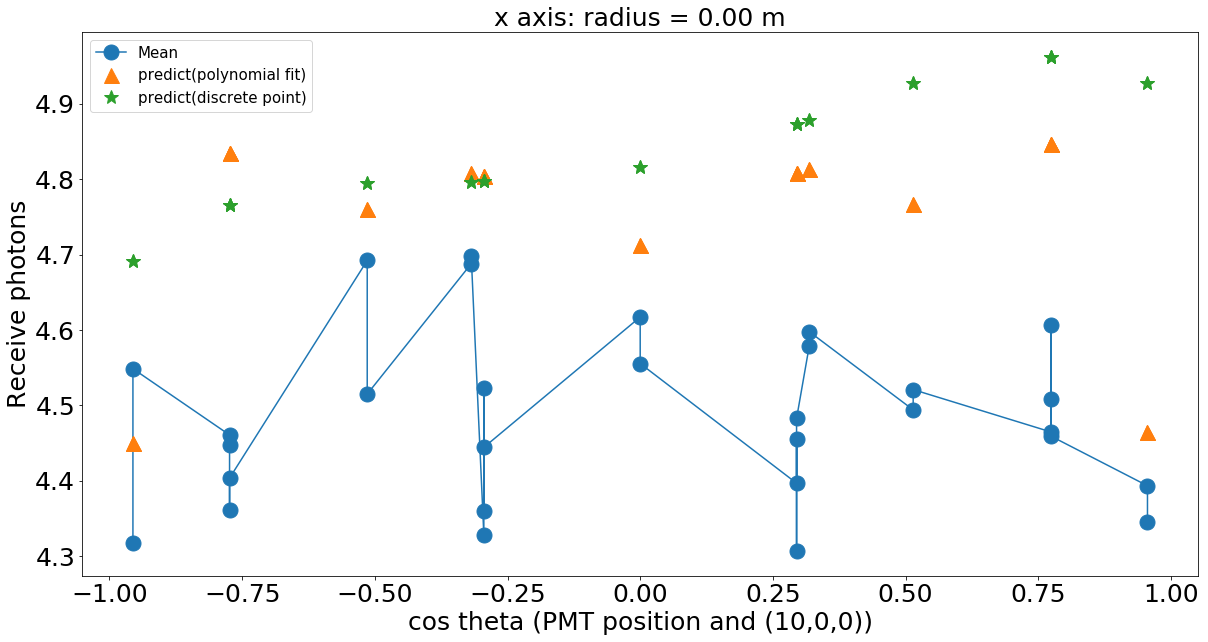

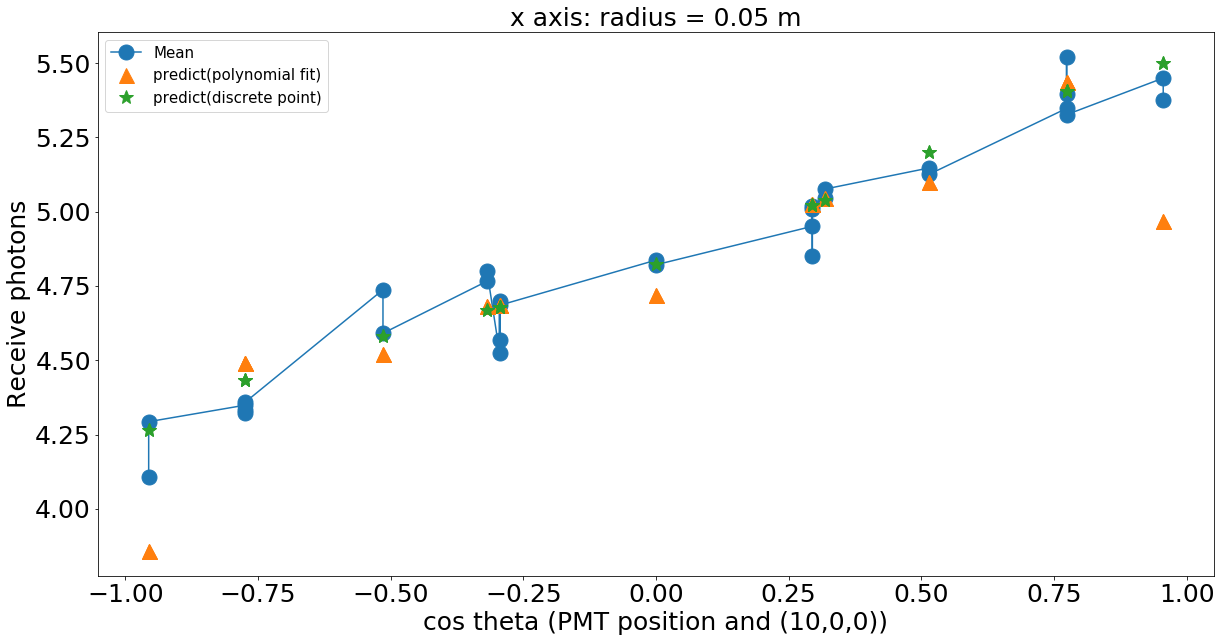

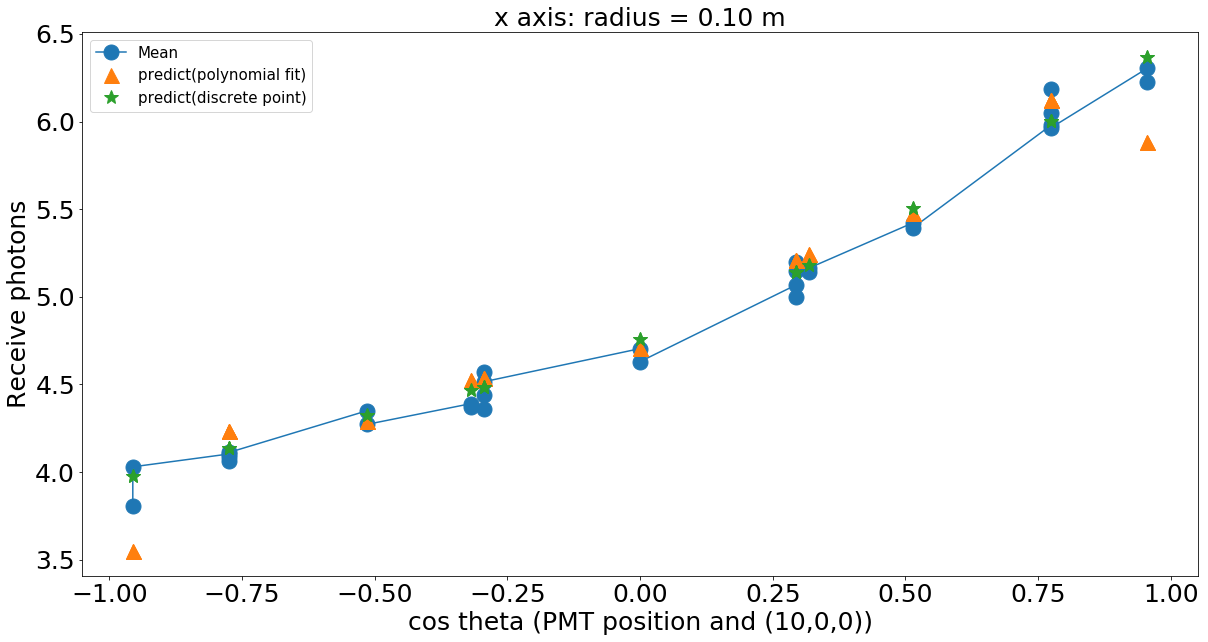

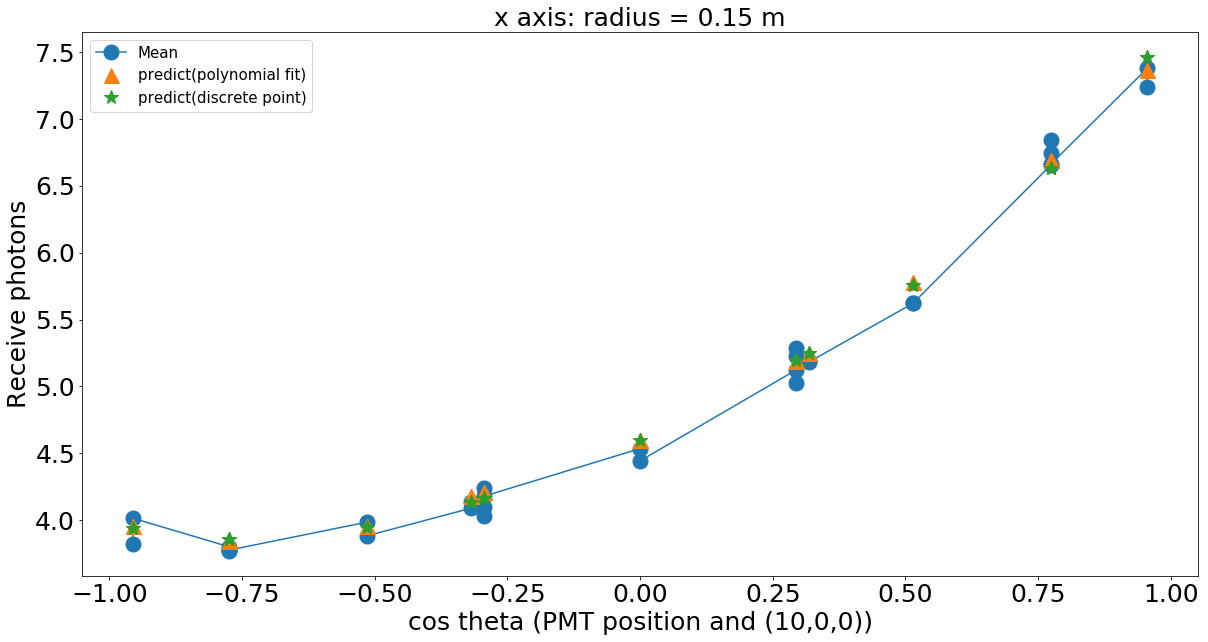

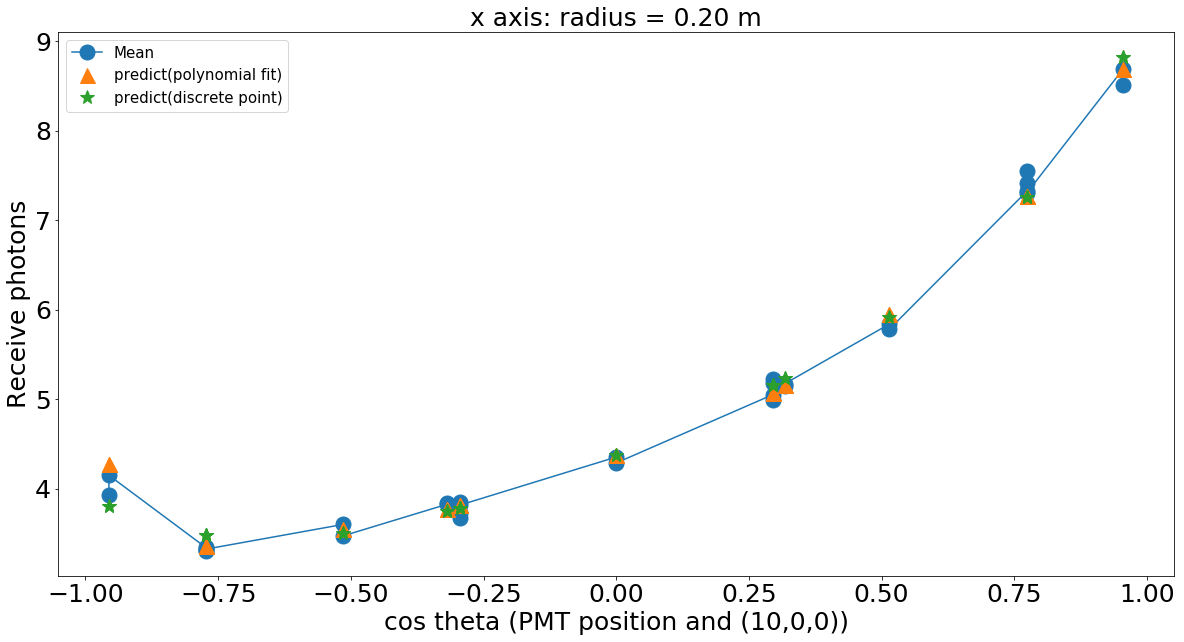

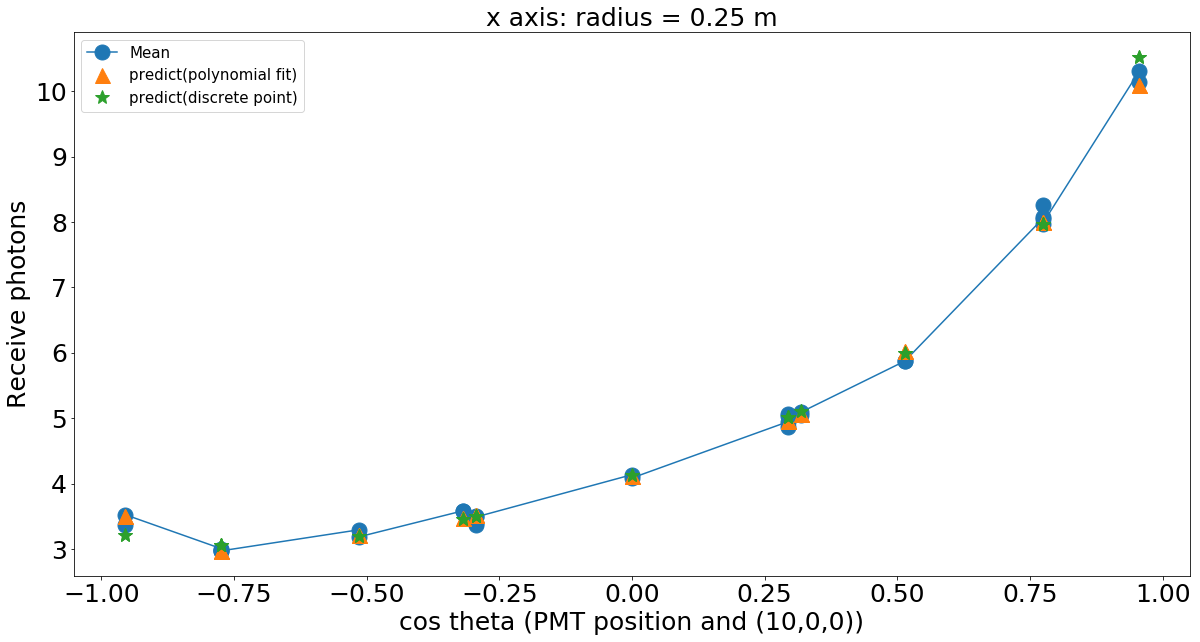

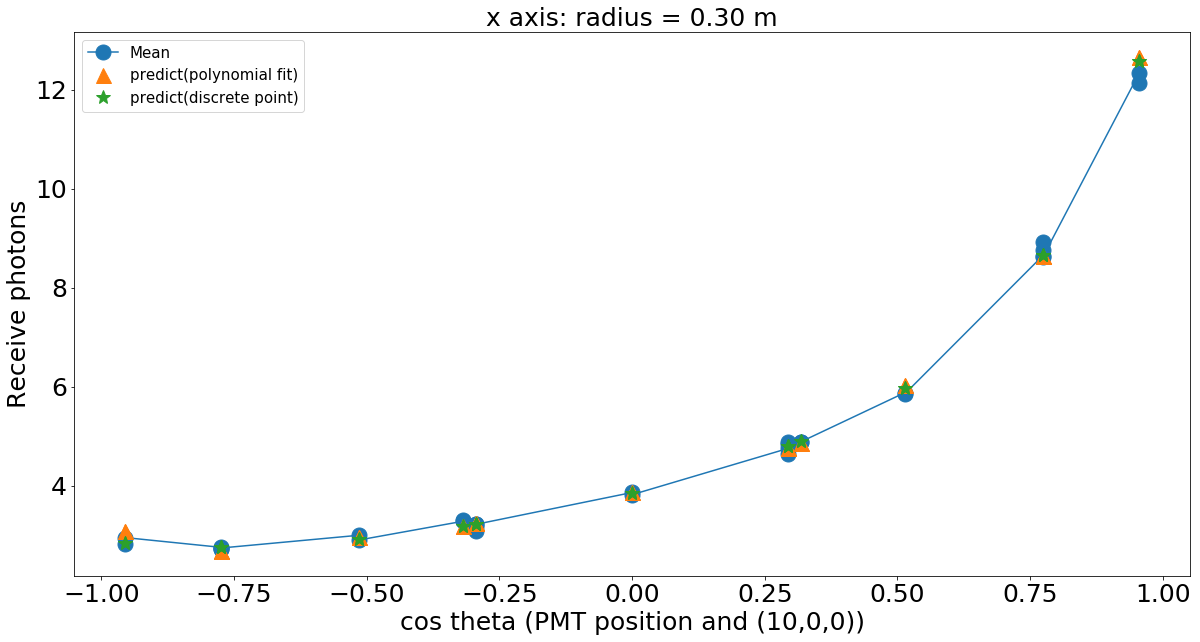

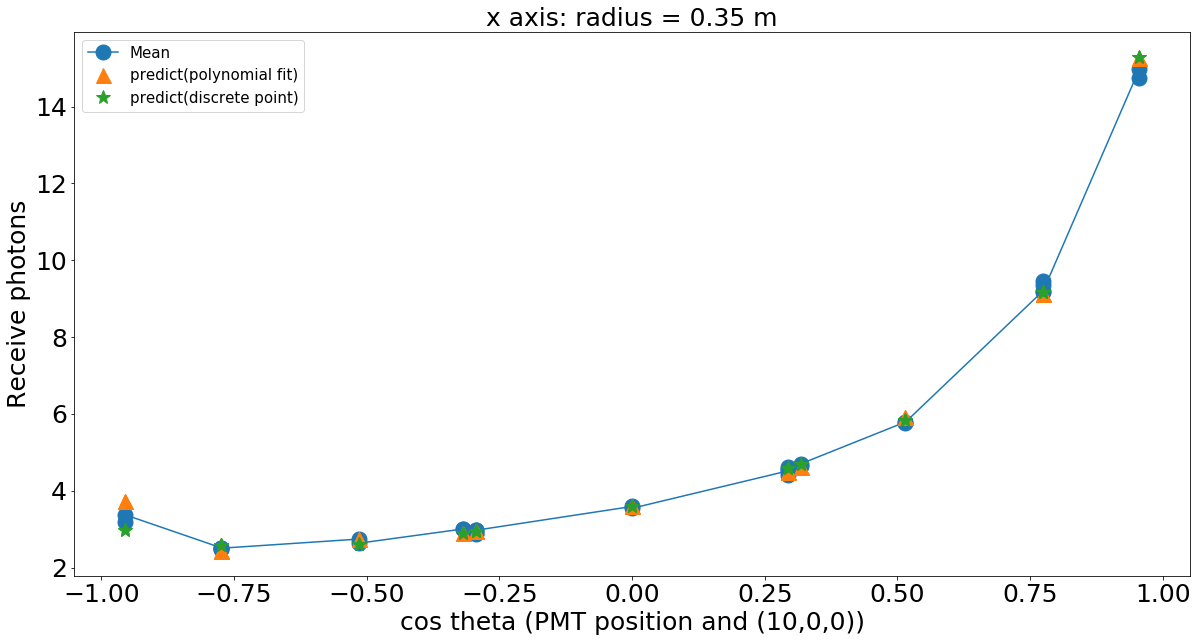

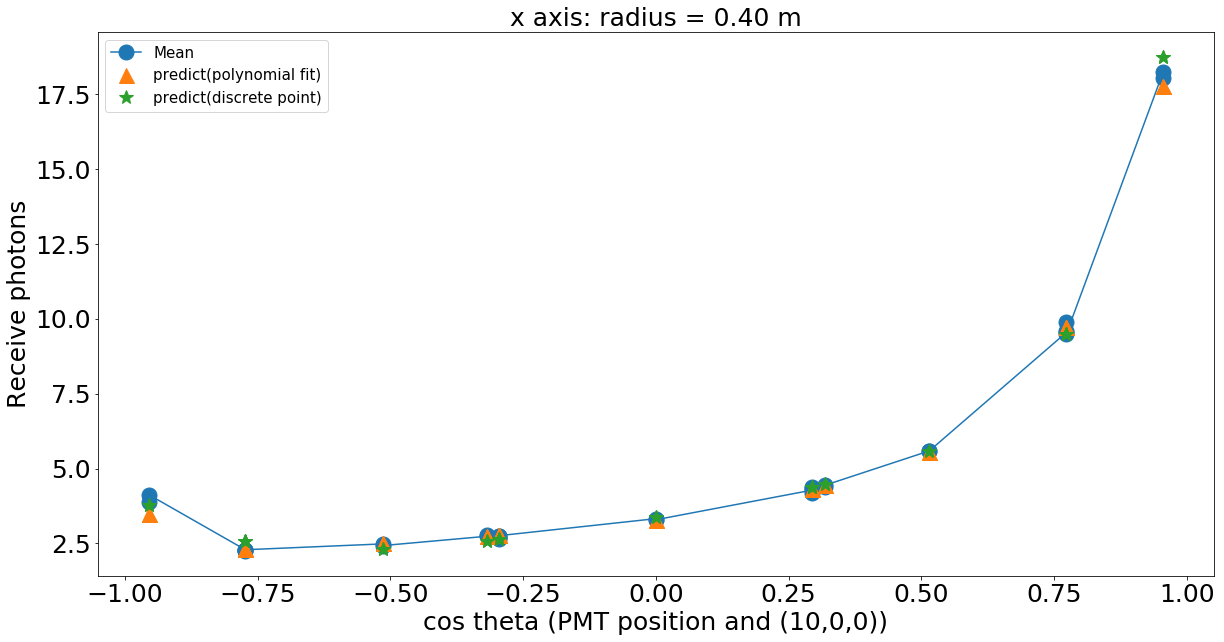

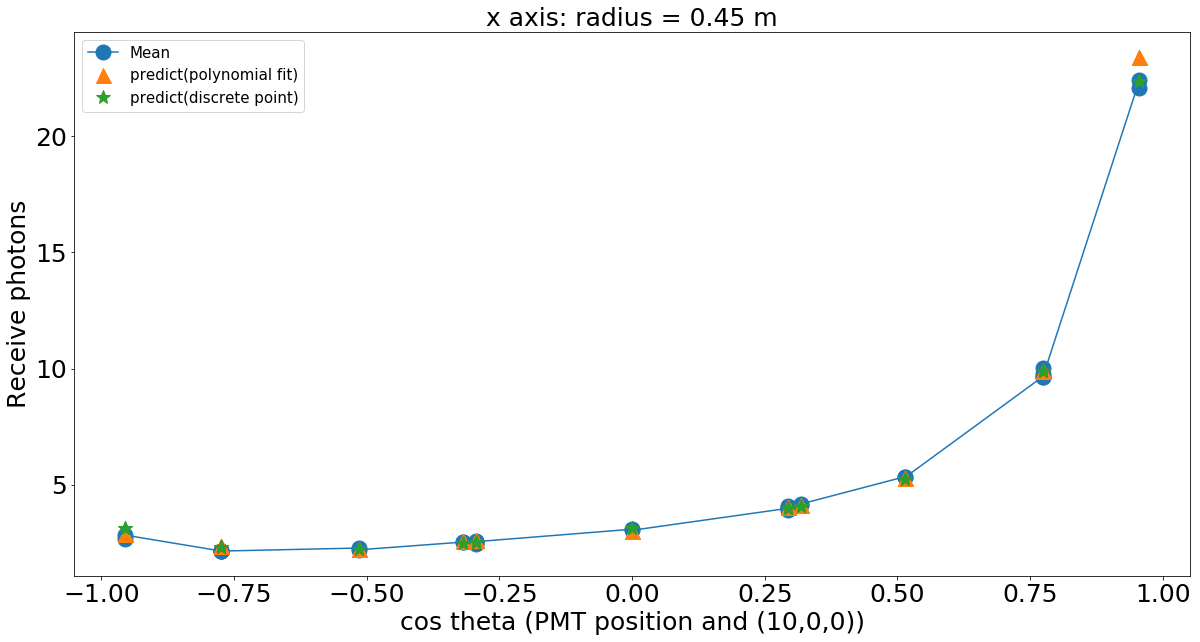

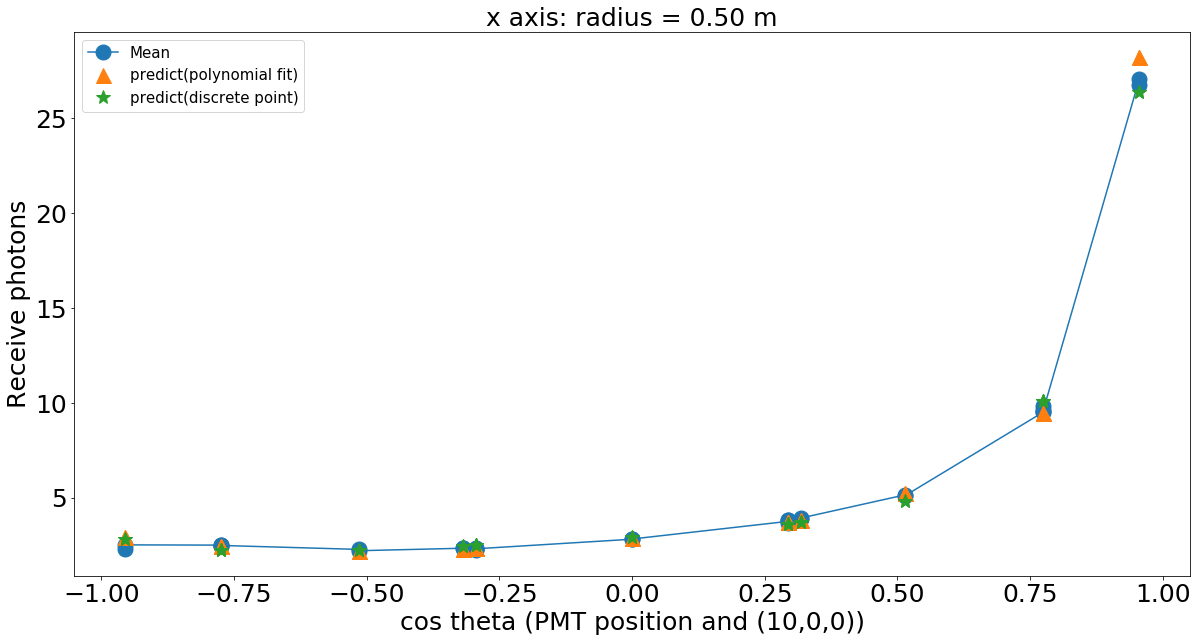

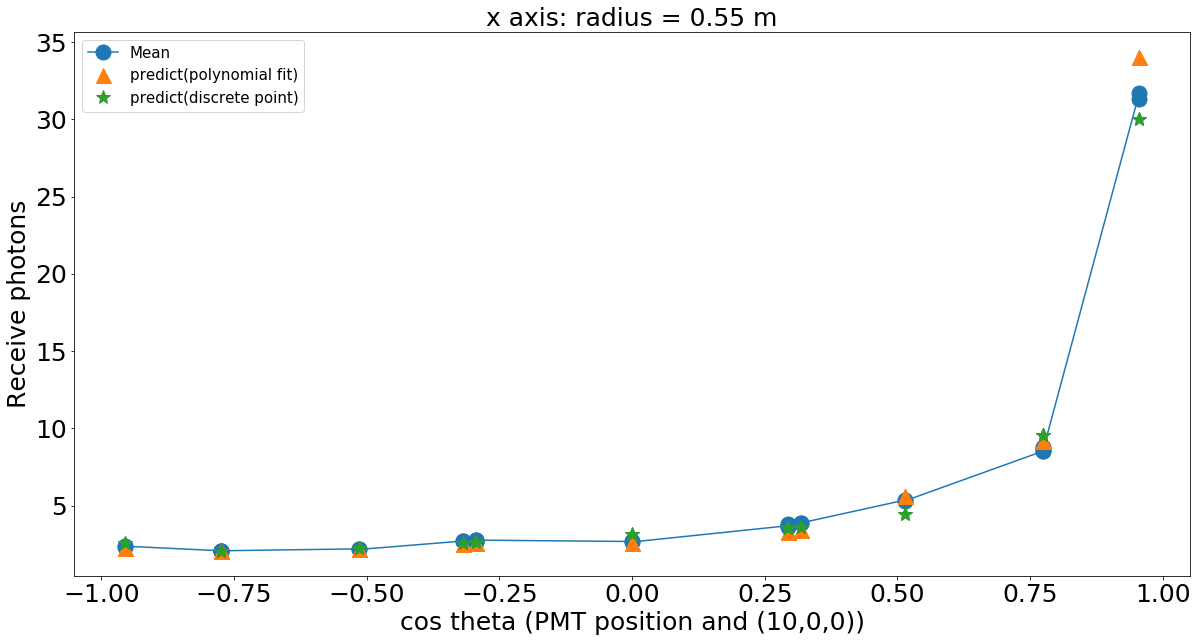

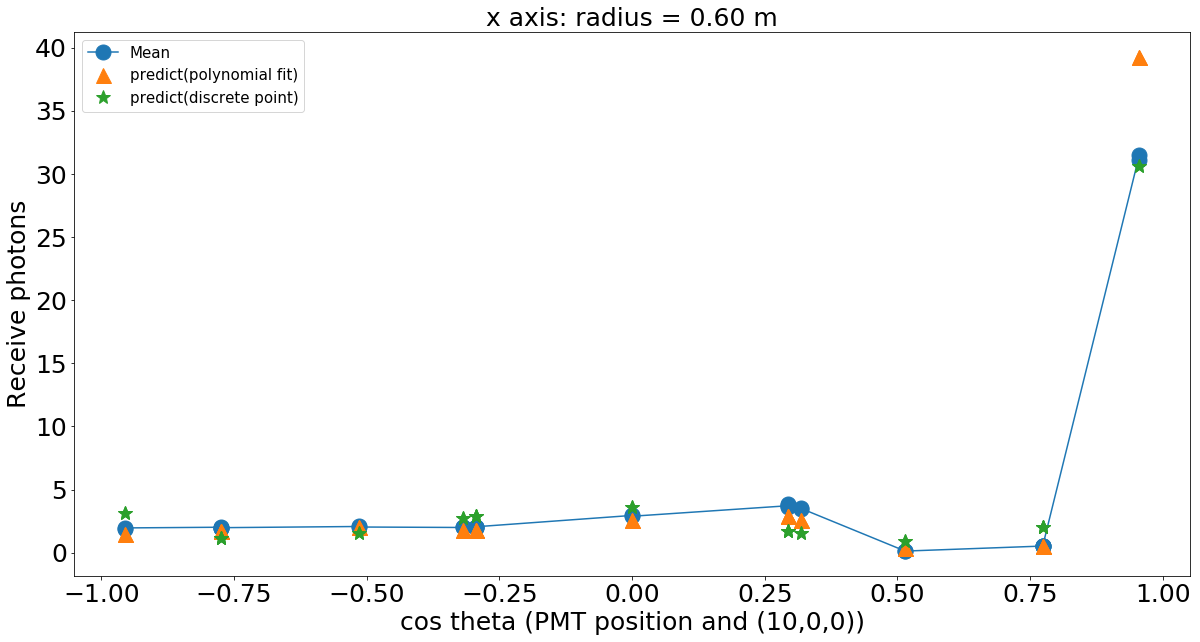

In [35]:
for i in np.arange(np.size(np.array(ax)[:,1])-1):
    PMT_pos = ReadPMT()
    v = np.array((10,0,0))
    cos_theta = np.dot(v,PMT_pos.T) / (norm(v)*norm(PMT_pos,axis=1))
    plt.figure(num = i, figsize=(20,10))
    index = np.argsort(cos_theta)
    plt.plot(cos_theta[index], np.array(ax)[i,index],'o-',markersize=15)
    plt.plot(cos_theta[index], expect_x[index,i*5],'^',markersize=15)
    plt.plot(cos_theta[index], np.array(bx)[index,i*5],'*',markersize=15)
    plt.xlabel('cos theta (PMT position and (10,0,0))', fontsize=25)
    plt.ylabel('Receive photons',fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)   
    plt.legend(['Mean','predict(polynomial fit)','predict(discrete point)'],fontsize=15)
    plt.title('x axis: radius = %.2f m' % (i*0.05), fontsize=25)
    plt.show()

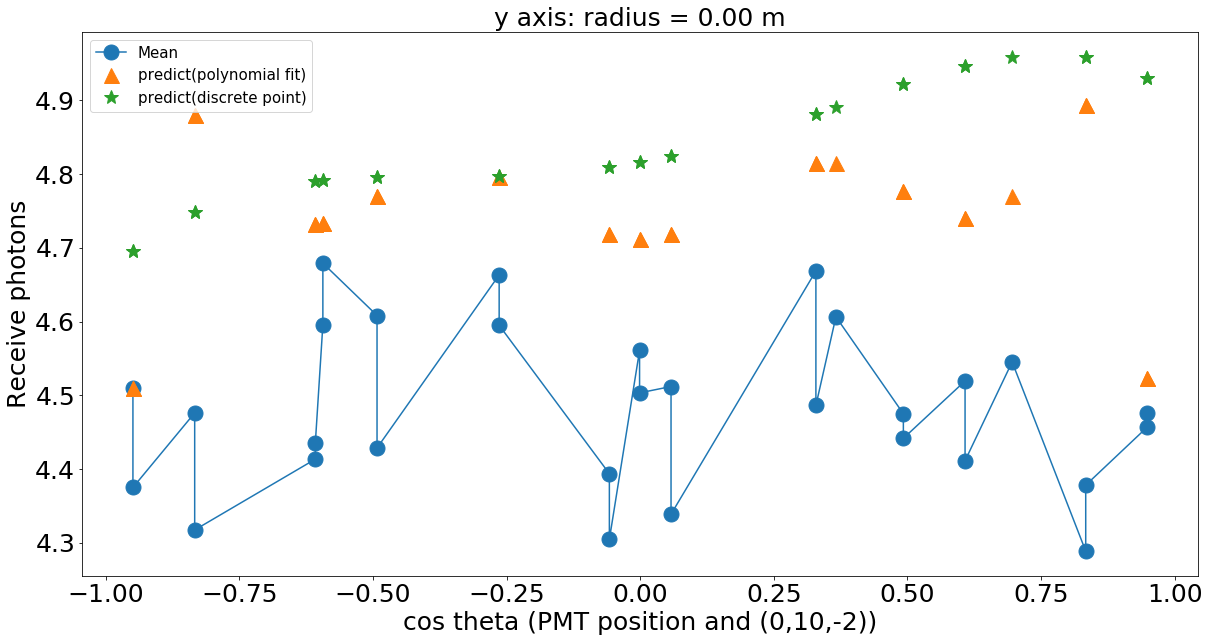

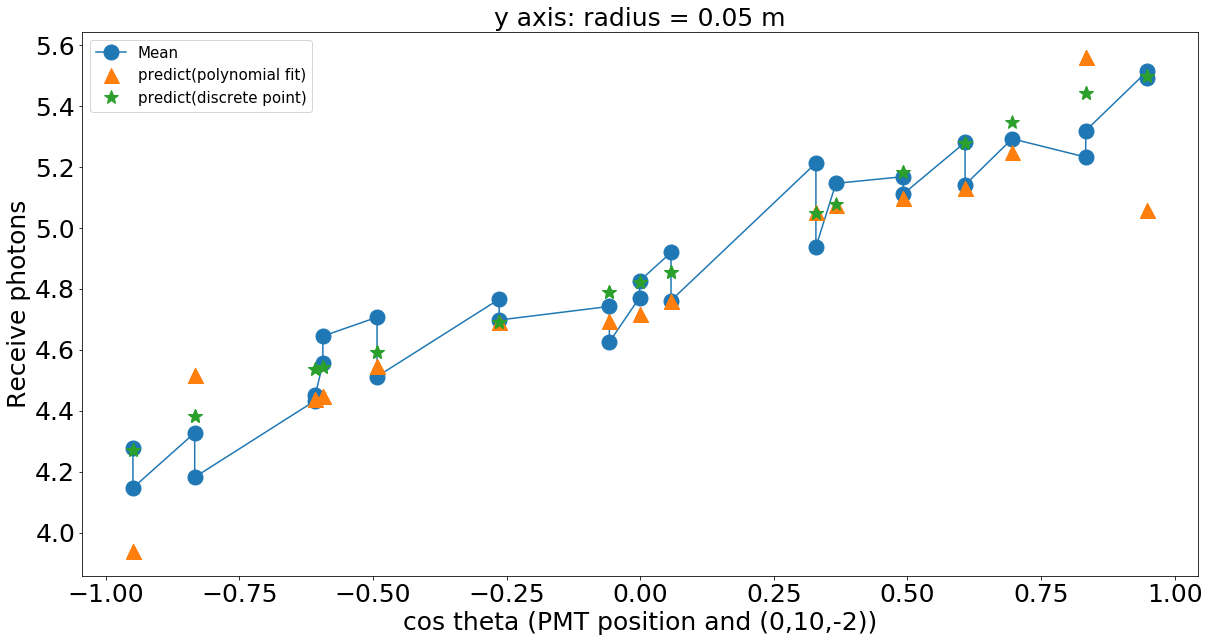

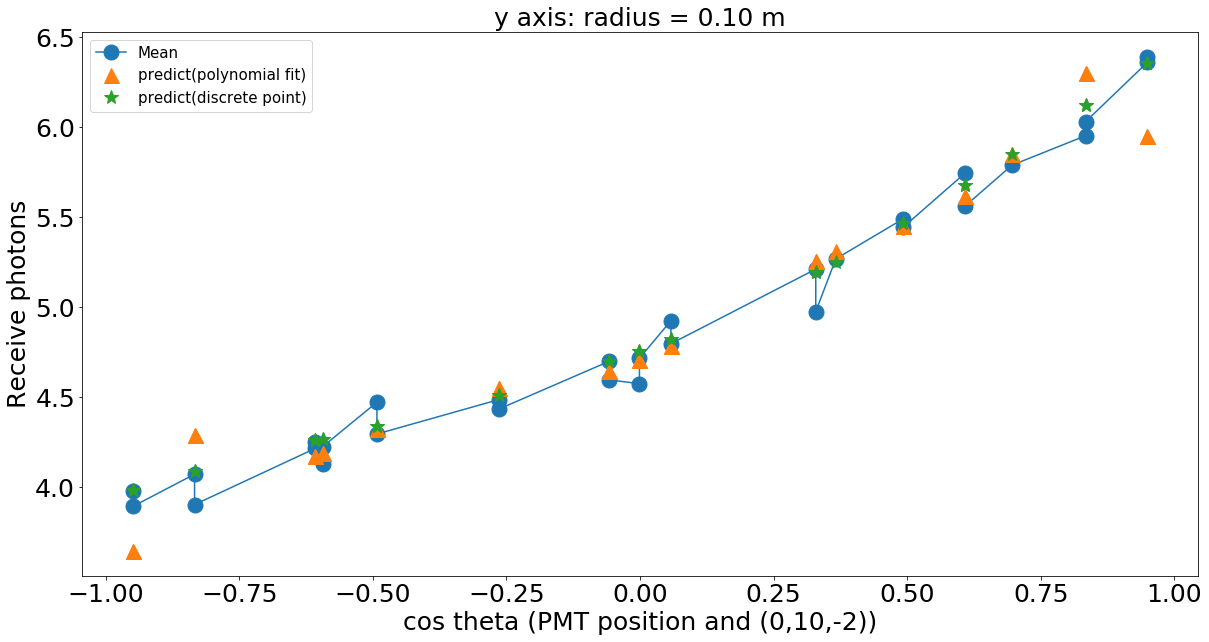

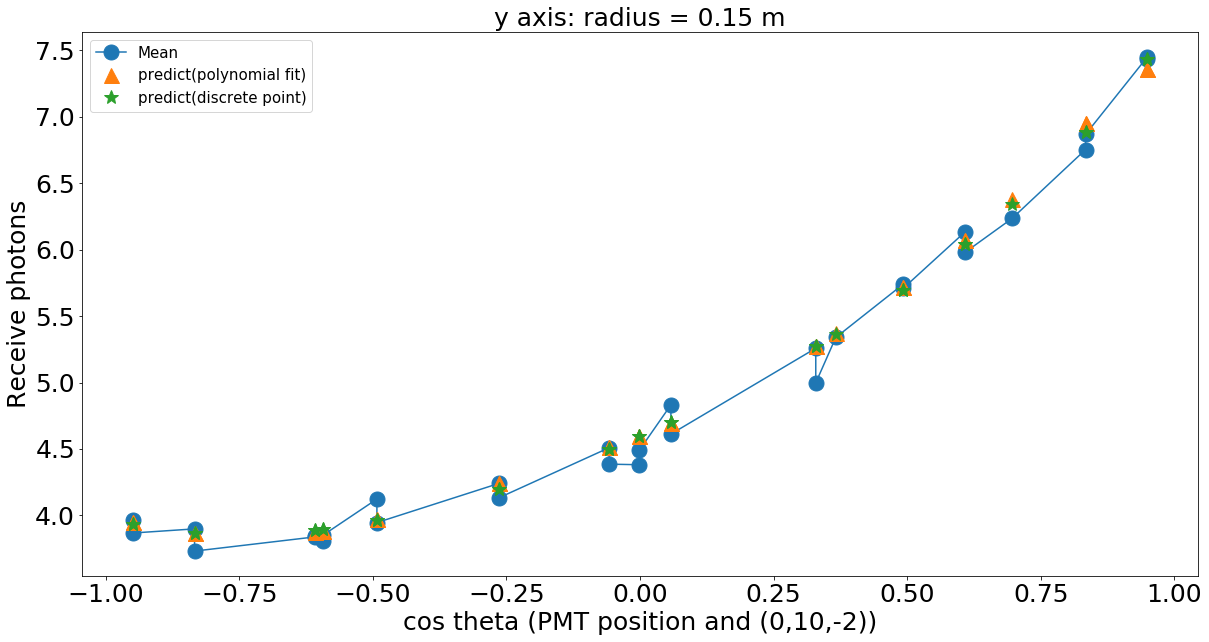

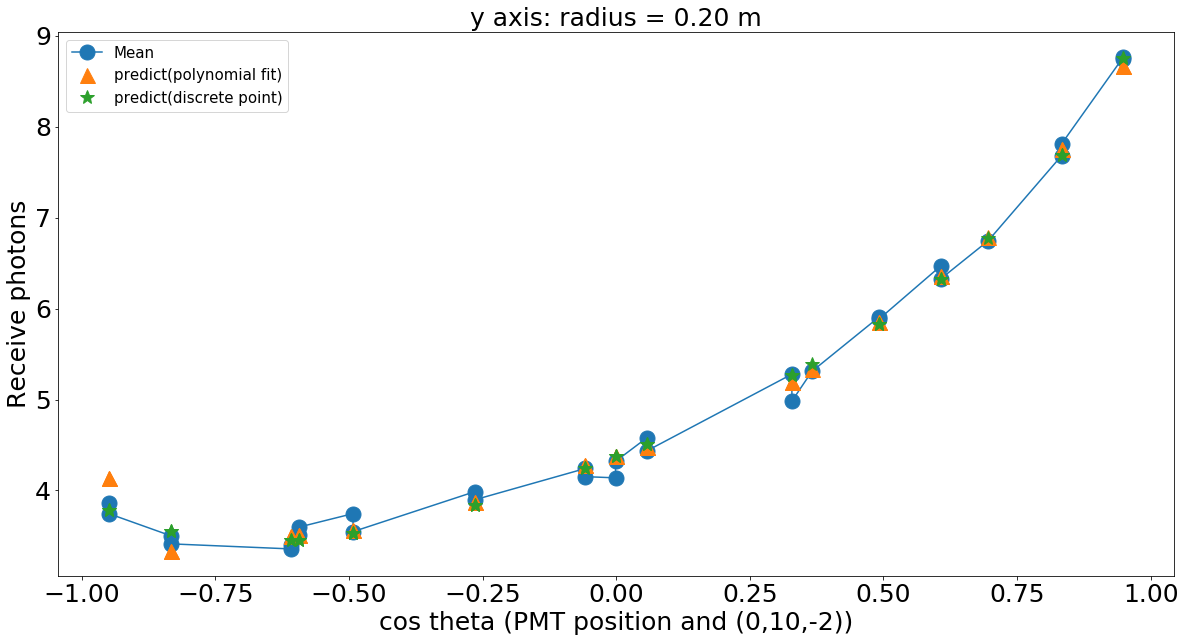

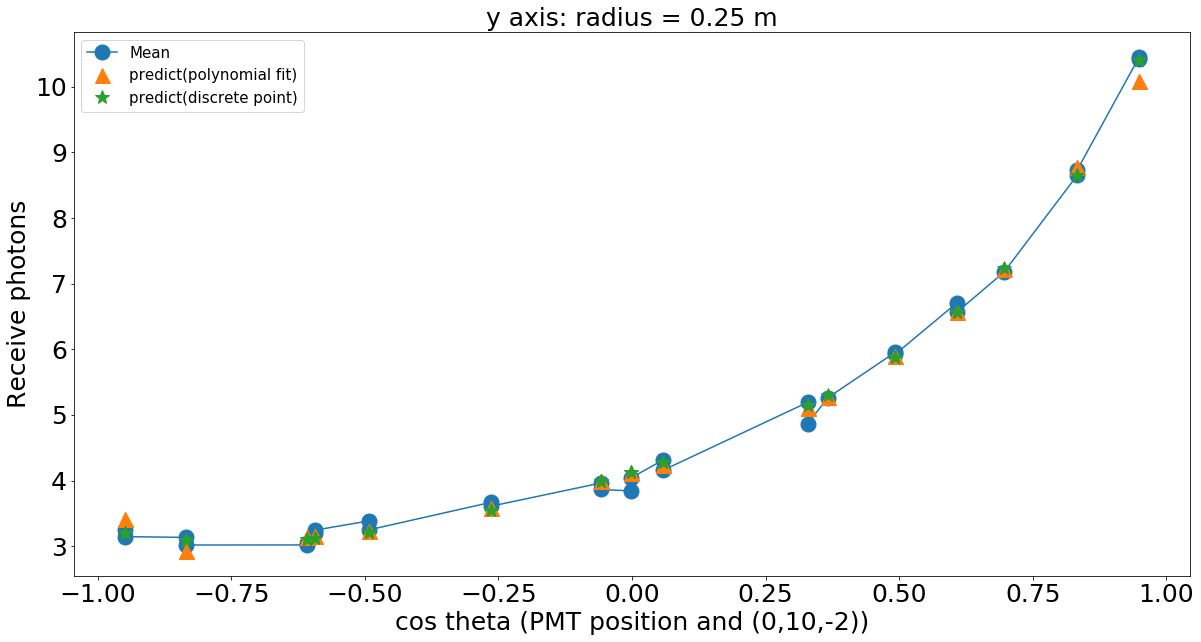

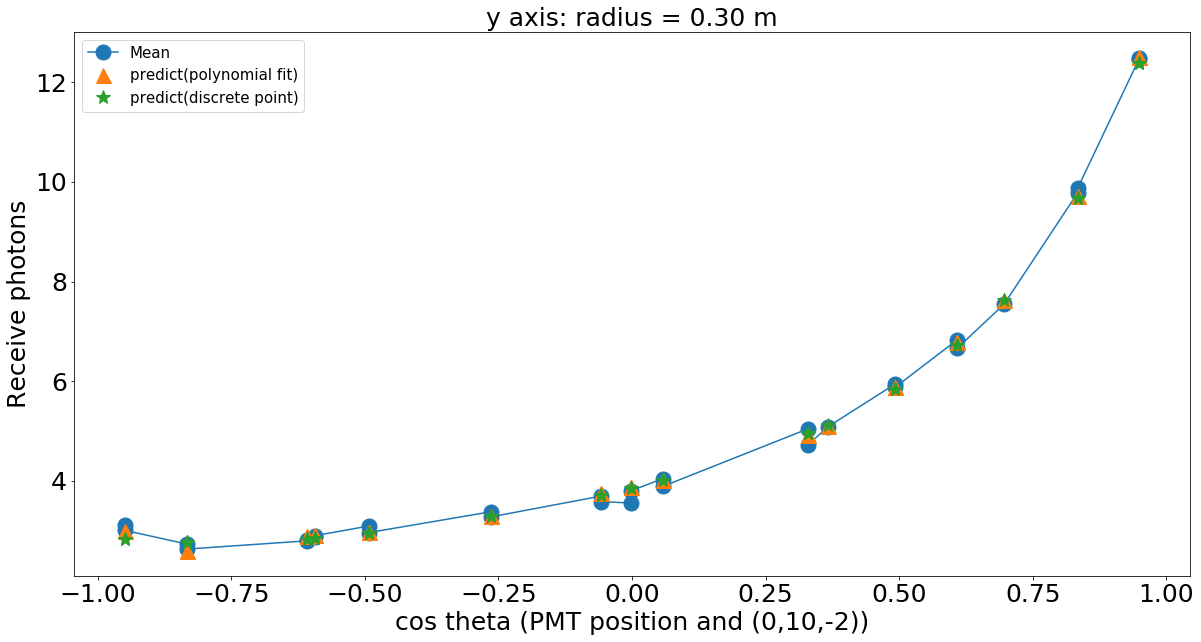

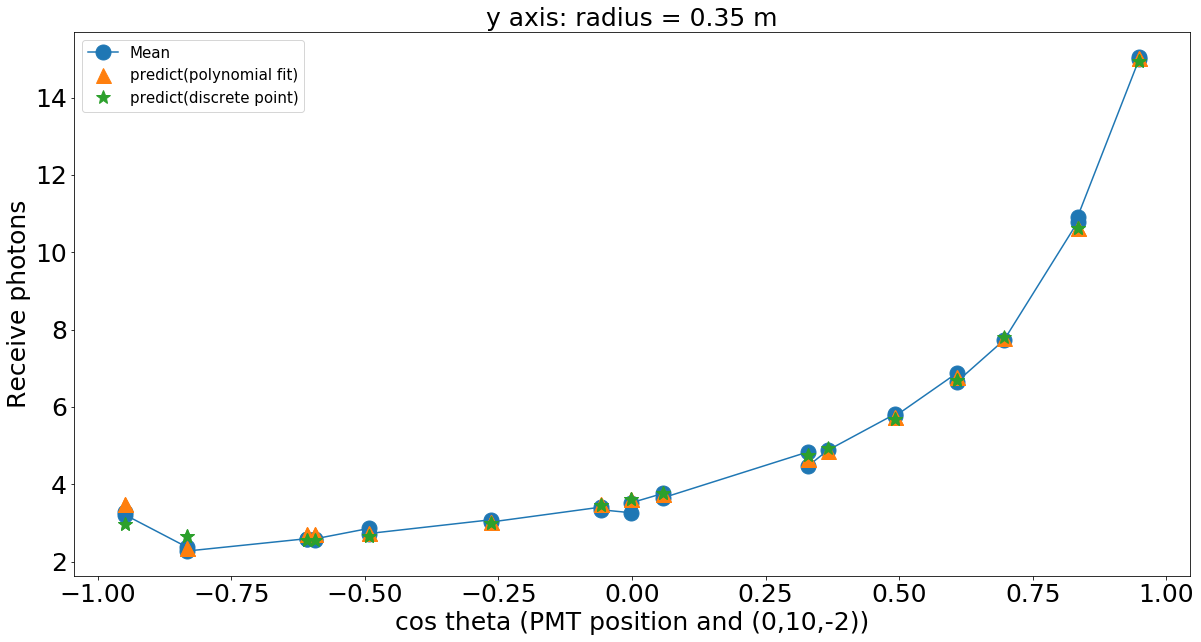

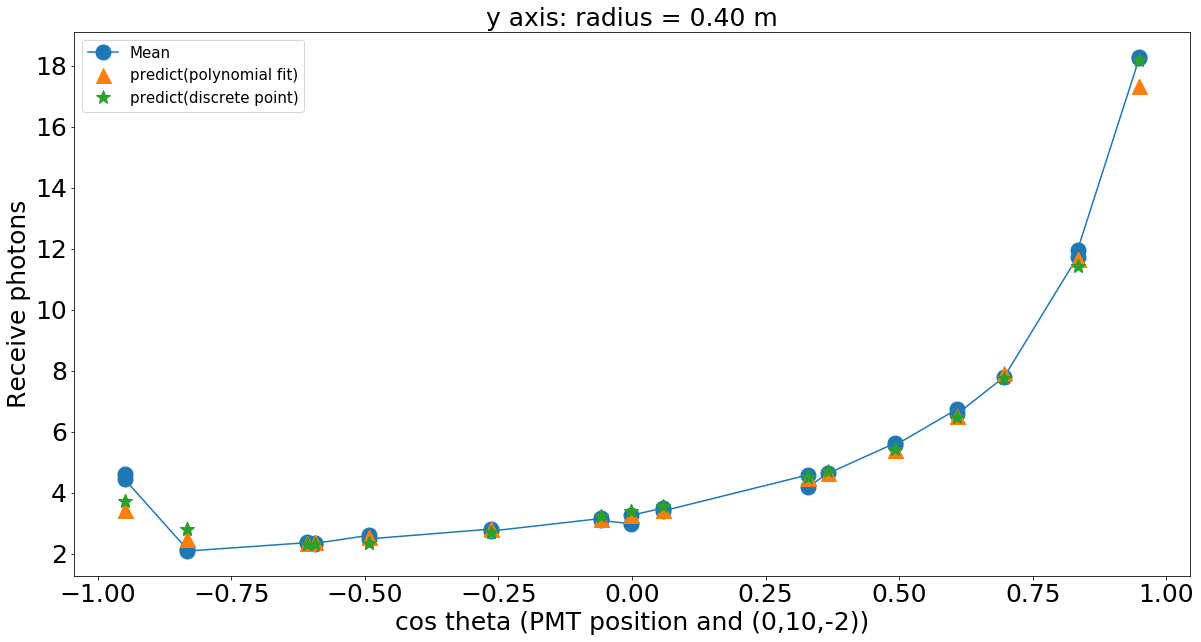

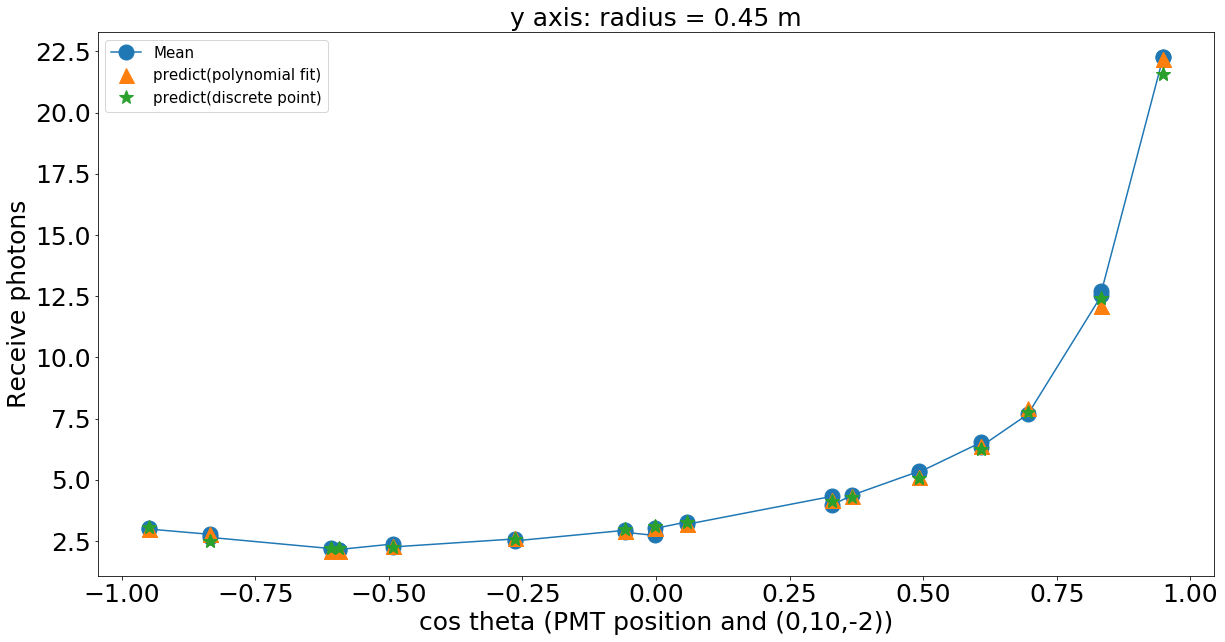

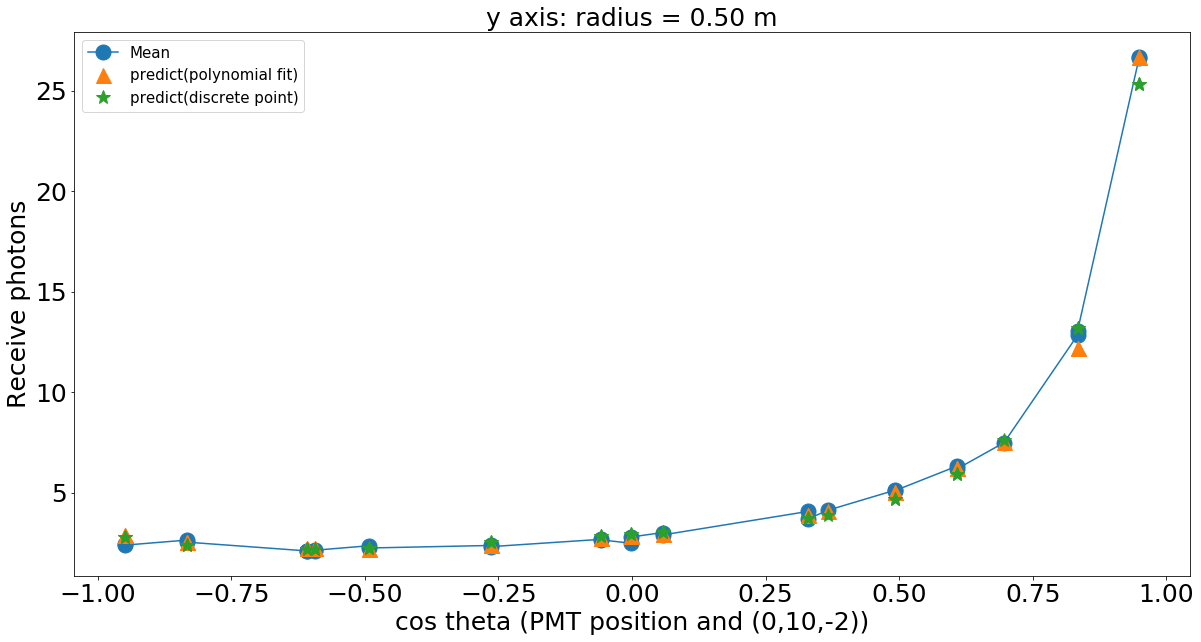

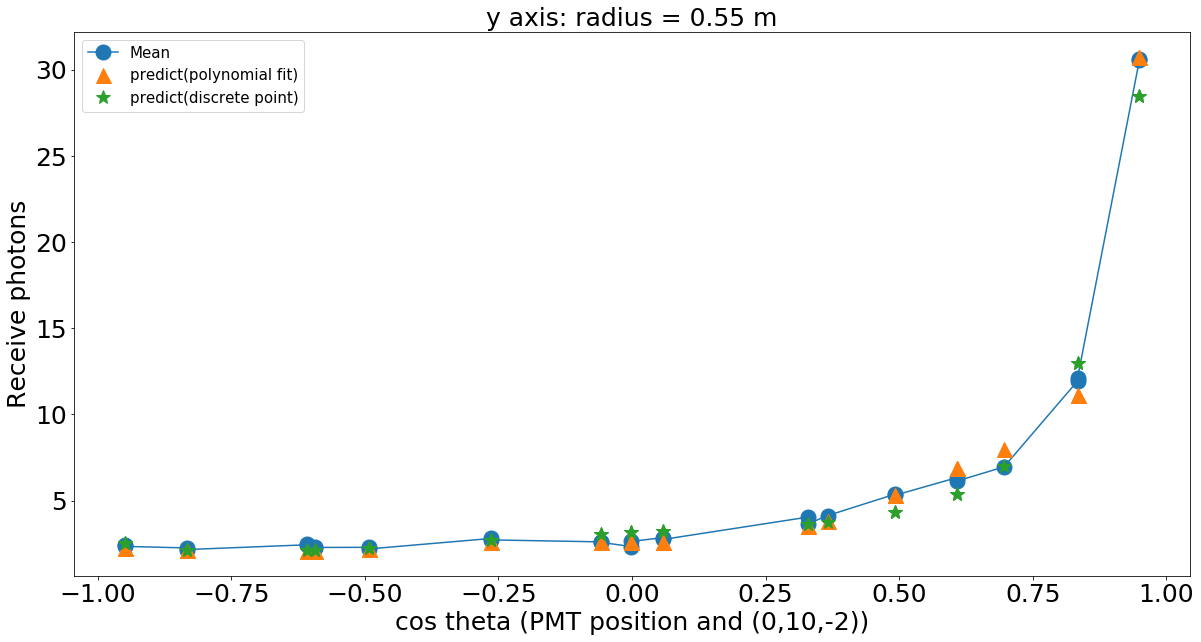

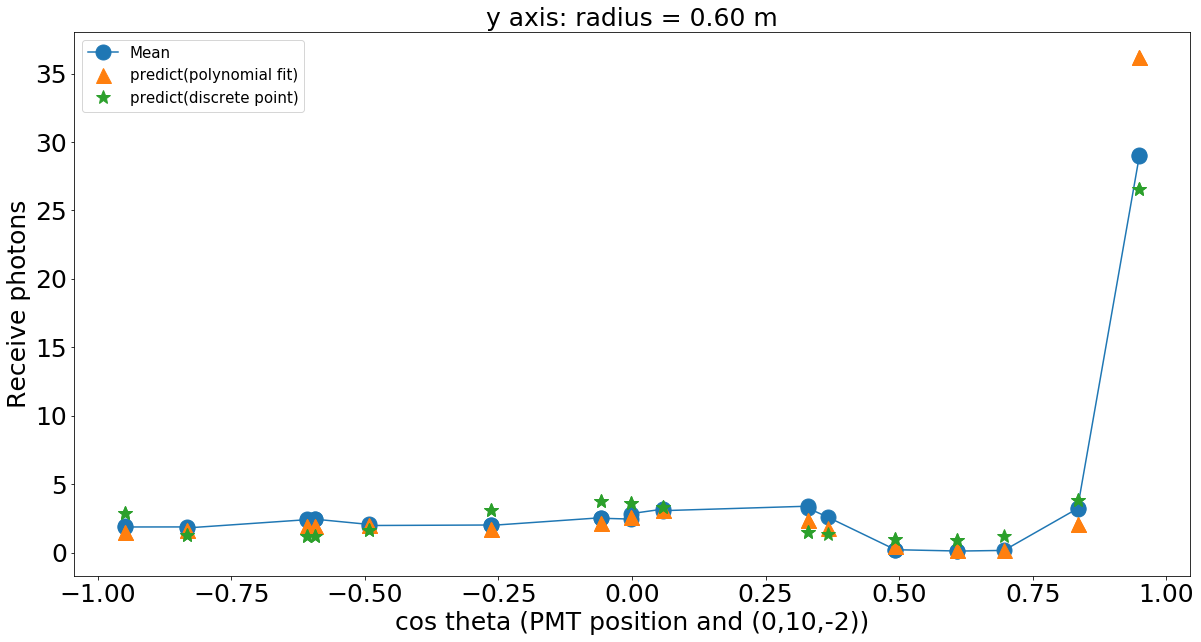

In [38]:
for i in np.arange(np.size(np.array(ay)[:,1])-1):
    PMT_pos = ReadPMT()
    v = np.array((0,10,-2))
    cos_theta = np.dot(v,PMT_pos.T) / (norm(v)*norm(PMT_pos,axis=1))
    plt.figure(num = i, figsize=(20,10))
    index = np.argsort(cos_theta)
    plt.plot(cos_theta[index], np.array(ay)[i,index],'o-',markersize=15)
    plt.plot(cos_theta[index], expect_y[index,i*5],'^',markersize=15)
    plt.plot(cos_theta[index], np.array(by)[index,i*5],'*',markersize=15)
    plt.xlabel('cos theta (PMT position and (0,10,-2))', fontsize=25)
    plt.ylabel('Receive photons',fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)   
    plt.legend(['Mean','predict(polynomial fit)','predict(discrete point)'],fontsize=15)
    plt.title('y axis: radius = %.2f m' % (i*0.05), fontsize=25)
    plt.show()

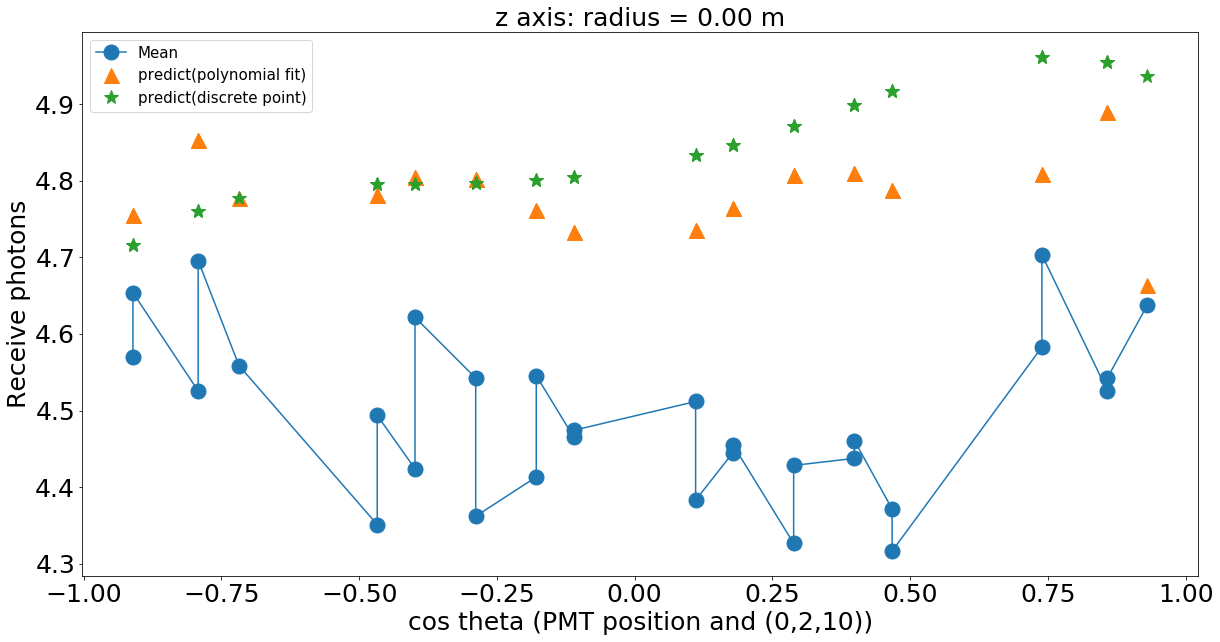

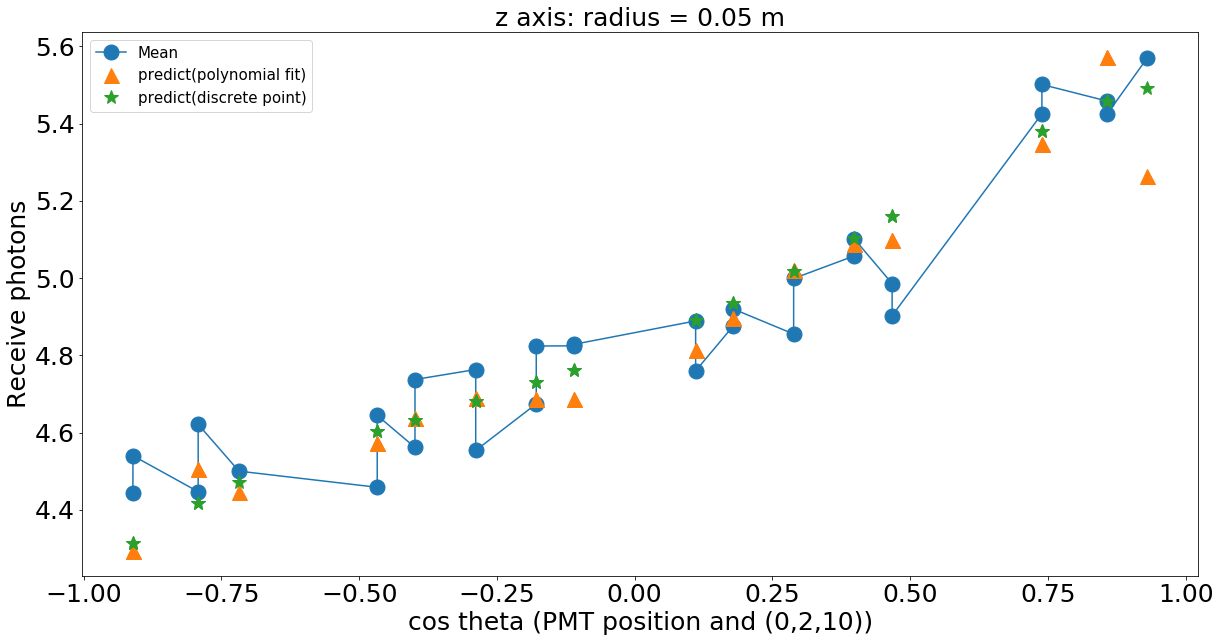

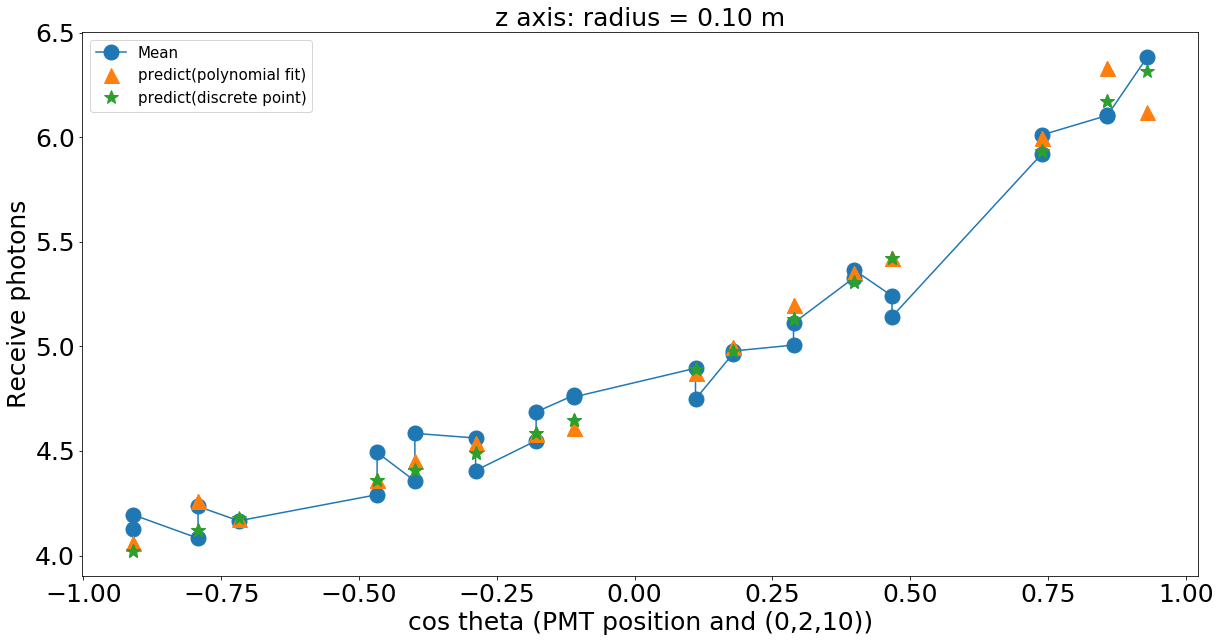

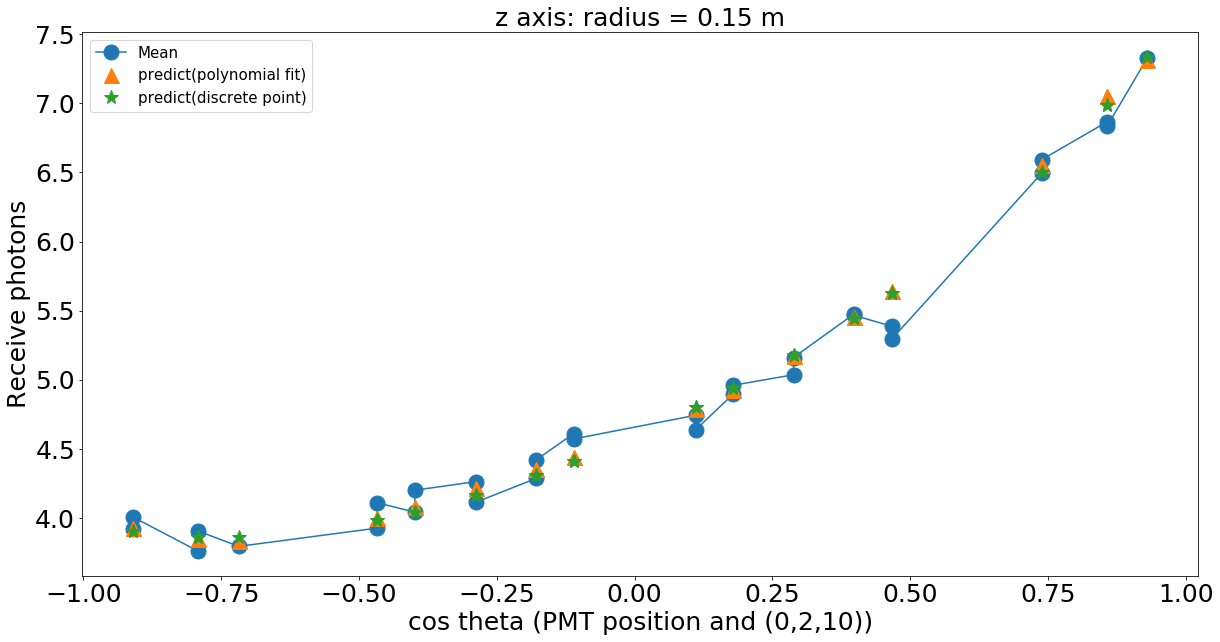

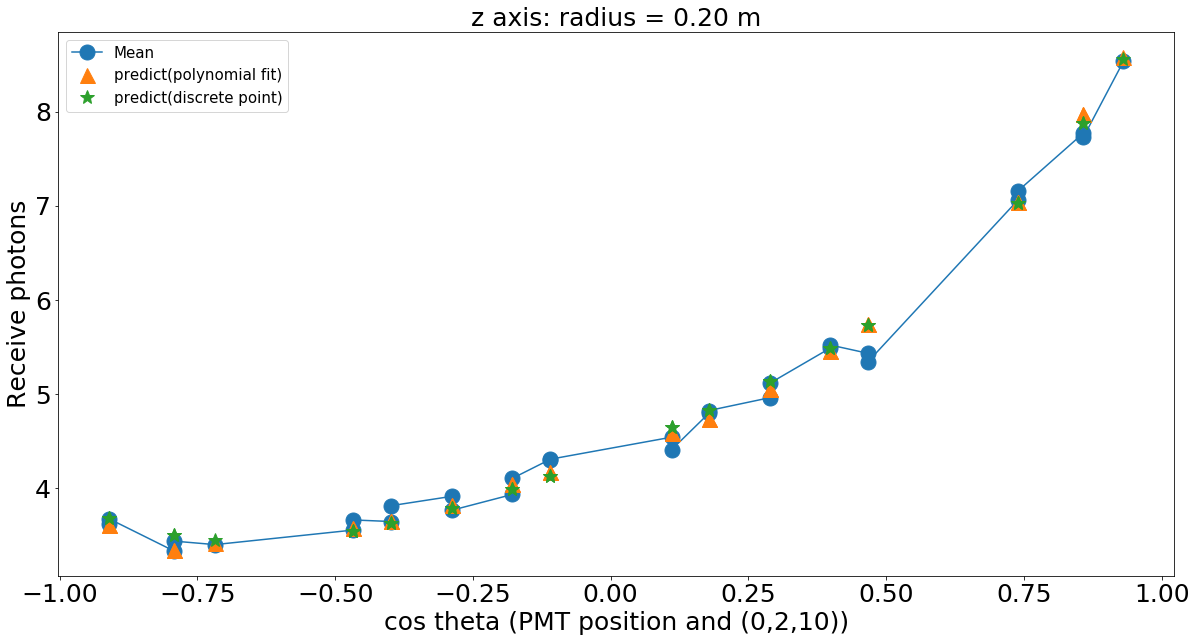

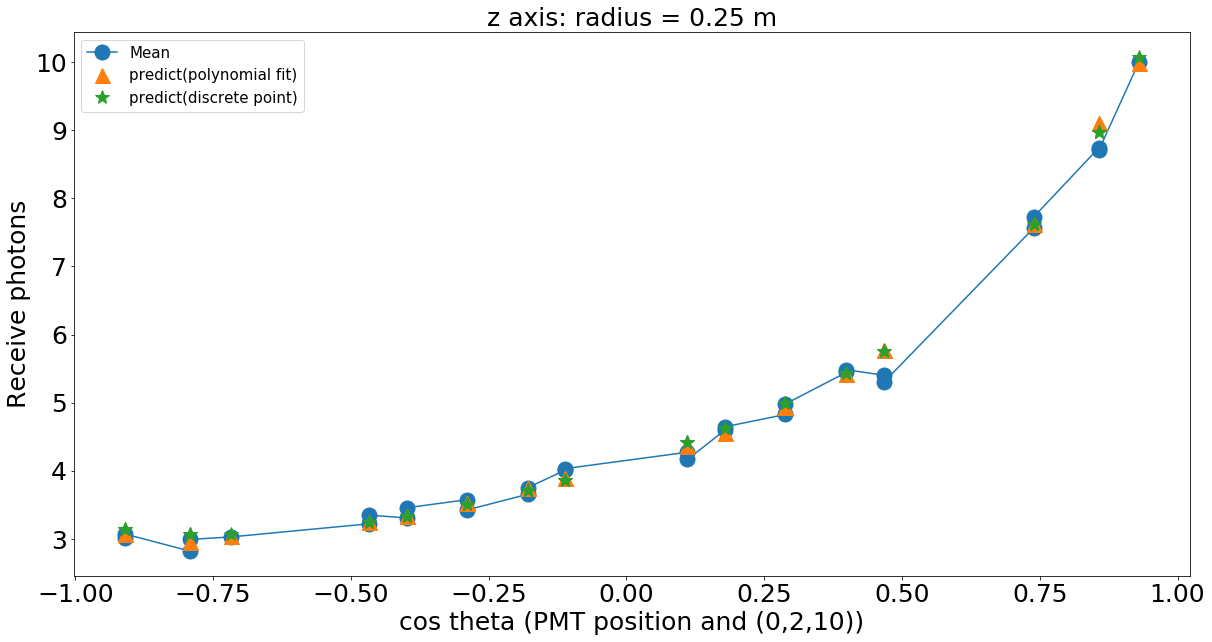

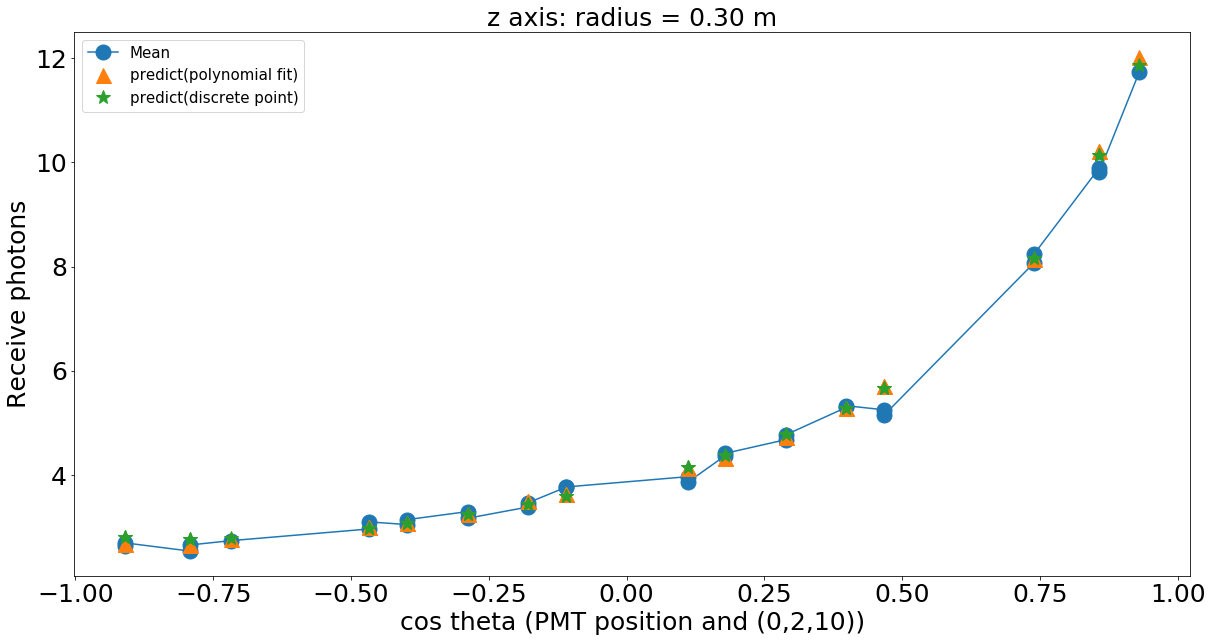

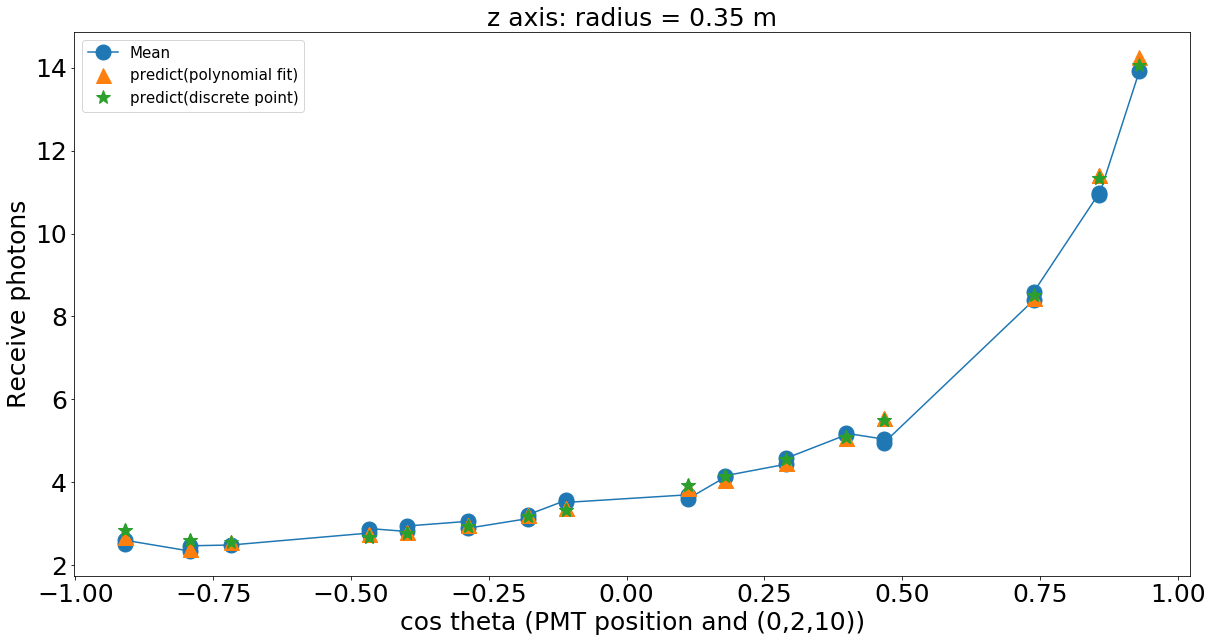

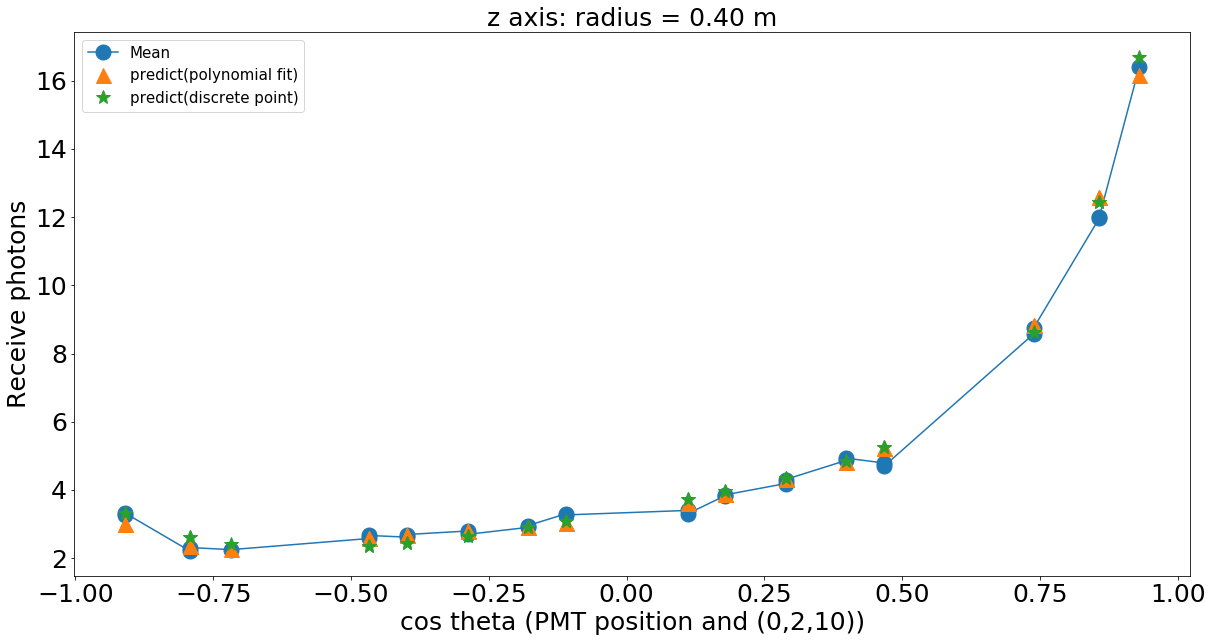

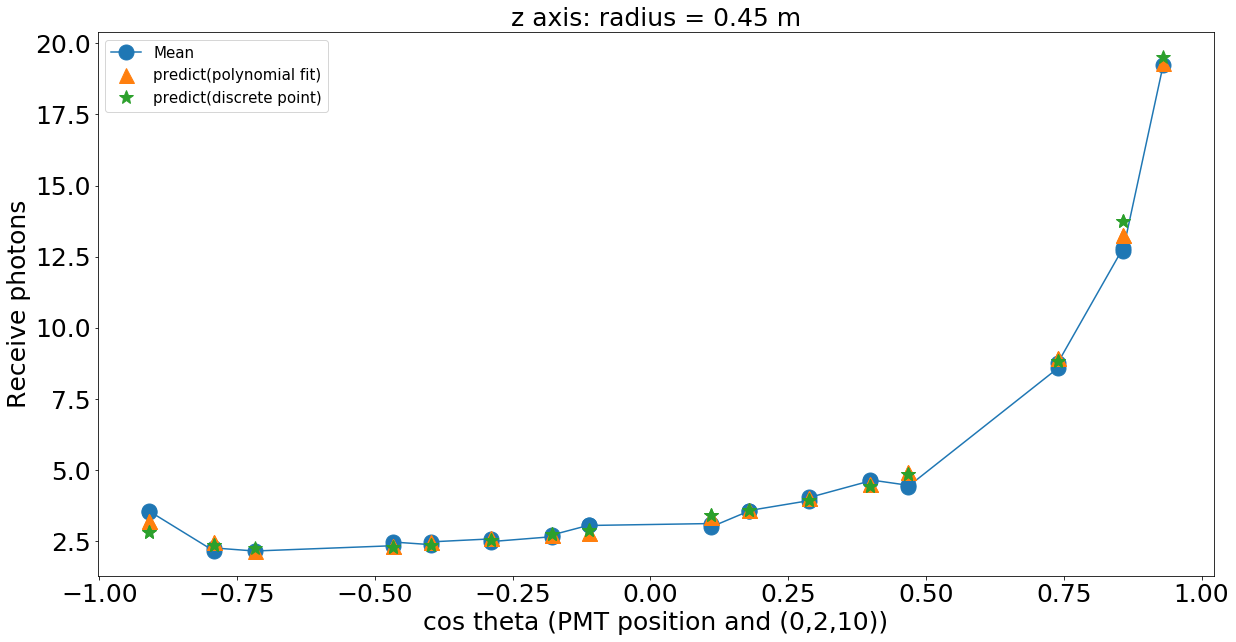

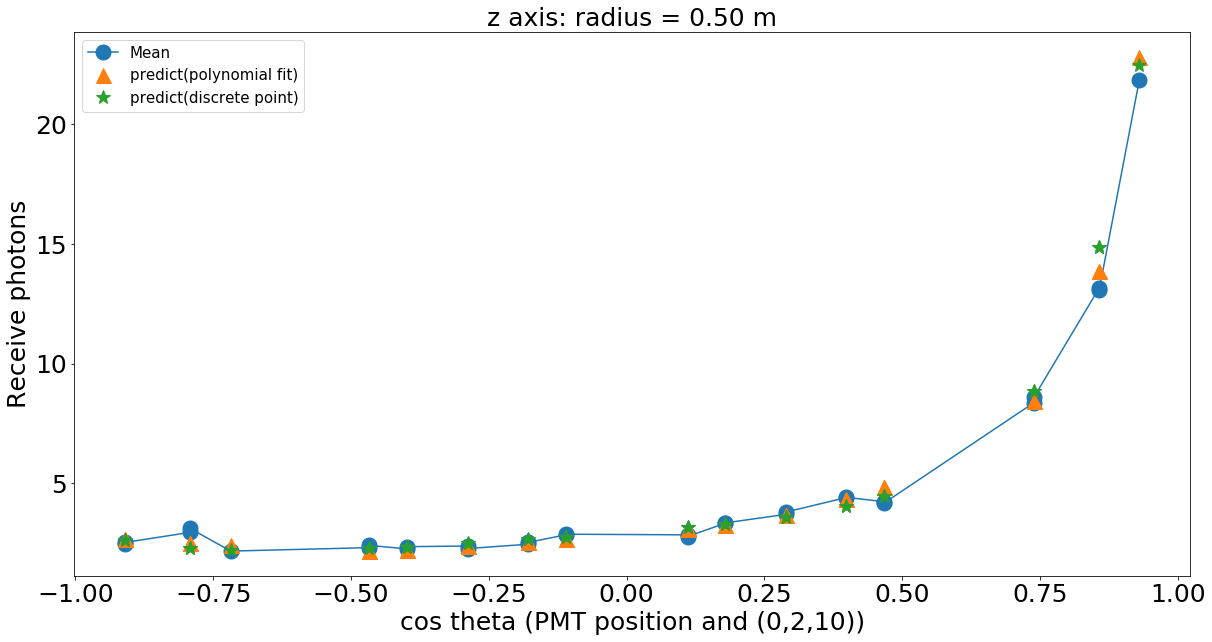

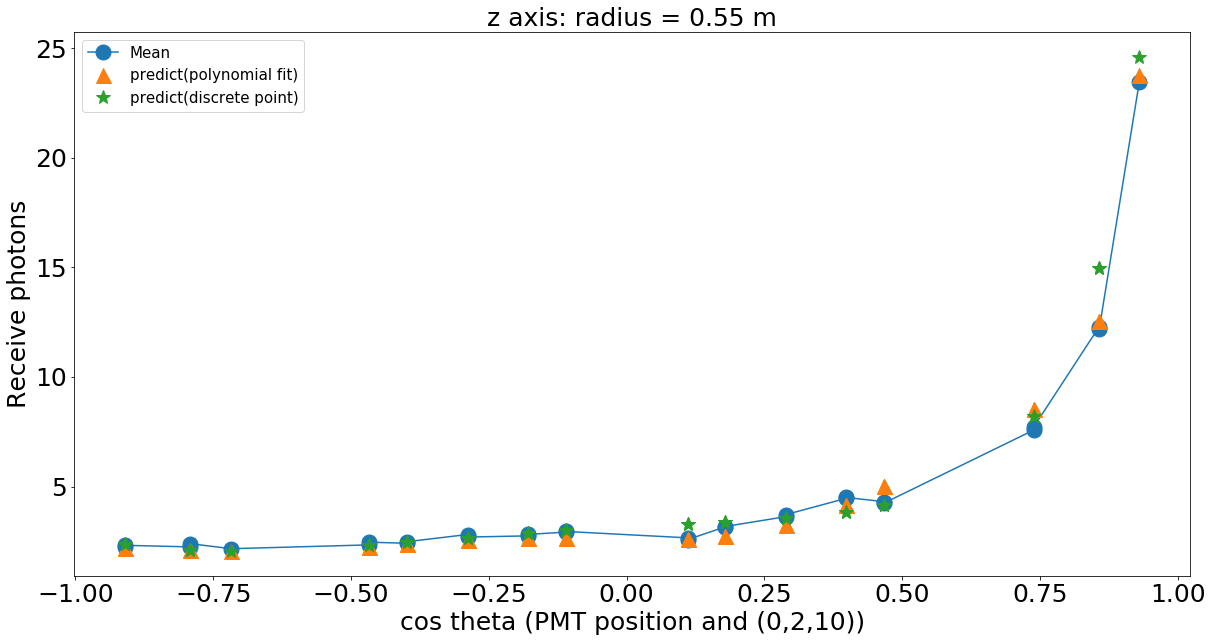

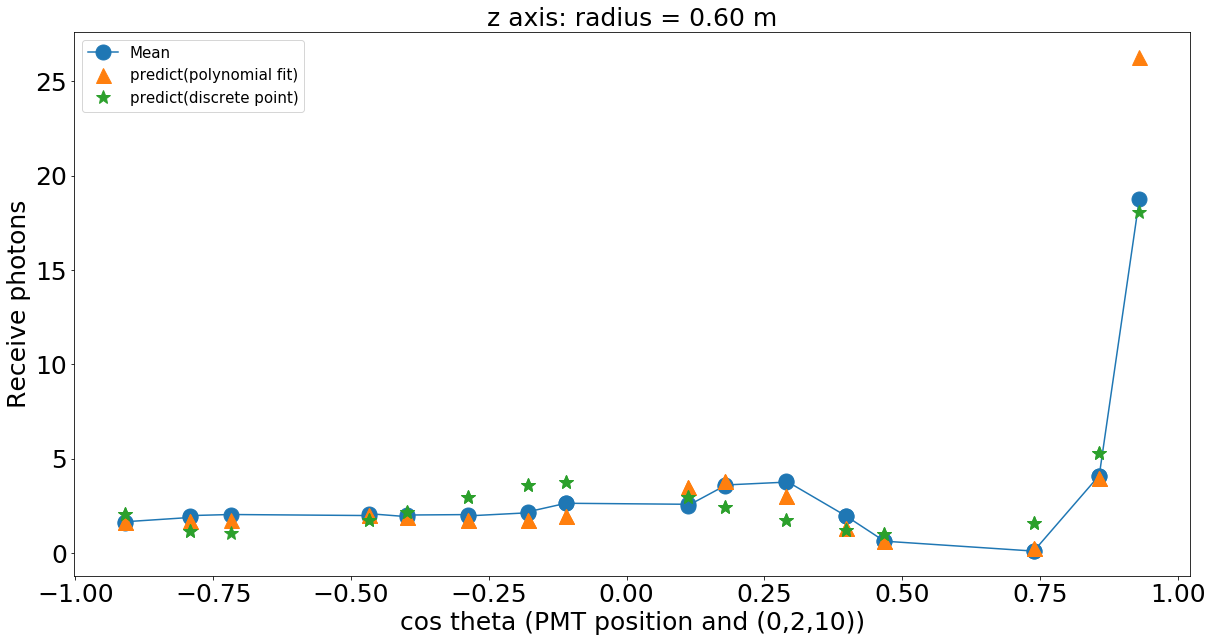

In [39]:
for i in np.arange(np.size(np.array(az)[:,1])-1):
    PMT_pos = ReadPMT()
    v = np.array((0,2,10))
    cos_theta = np.dot(v,PMT_pos.T) / (norm(v)*norm(PMT_pos,axis=1))
    plt.figure(num = i, figsize=(20,10))
    index = np.argsort(cos_theta)
    plt.plot(cos_theta[index], np.array(az)[i,index],'o-',markersize=15)
    plt.plot(cos_theta[index], expect_z[index,i*5],'^',markersize=15)
    plt.plot(cos_theta[index], np.array(bz)[index,i*5],'*',markersize=15)
    plt.xlabel('cos theta (PMT position and (0,2,10))', fontsize=25)
    plt.ylabel('Receive photons',fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)   
    plt.legend(['Mean','predict(polynomial fit)','predict(discrete point)'],fontsize=15)
    plt.title('z axis: radius = %.2f m' % (i*0.05), fontsize=25)
    plt.show()

## 